In [4]:
!pip install seaborn aeon

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import sqlite3
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ana_utils import convert_listlike_cols, db_path, font_size, font_size_large, df_to_latex_table
import json
from math import inf
import aeon

In [6]:
METRIC = "r2_score"

In [7]:
def sec2str(seconds):
    if seconds < 60:
        return str(seconds) + "s"
    elif seconds < 60*60:
        return str(seconds // 60) + "min"
    else:
        return str(seconds // (60*60)) + "h"

conn = sqlite3.connect(db_path)
#df = pd.read_sql(f"SELECT model, search_space_hash, {METRIC}, data_config_hash, data_id, search_space_name FROM results ", conn)
df = pd.read_sql(f"SELECT results.model, {METRIC}, data_config_hash, data_id, json_extract(search_spaces.config, '$.fit_kwargs') as fit_kwargs FROM results join search_spaces on results.search_space_hash == search_spaces.hash_key", conn)
conn.close()
df = convert_listlike_cols(df)
#list(df[df["model"]=="AutoGluon"]["config"])[0]
df["Model"] = df[["model", "fit_kwargs"]].apply(lambda x: x["model"] if x["fit_kwargs"] is None else f"{x['model']} ({sec2str(json.loads(x['fit_kwargs'])['time_limit'])})", axis=1)
df = df.drop(["fit_kwargs"], axis=1)
df[METRIC] = df[METRIC].apply(
    lambda x: sum(x) / len(x) if x else None
)
# df = df[(df["model"] != "AutoGluon") | (df["Model"] == "AutoGluon (1h)")]
df[df["model"] == "AutoGluon"]

,model,r2_score,data_config_hash,data_id,Model
625,AutoGluon,0.584806,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,0,AutoGluon (1min)
627,AutoGluon,0.995828,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,2,AutoGluon (1min)
628,AutoGluon,0.957469,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,1,AutoGluon (1min)
629,AutoGluon,0.924139,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,5,AutoGluon (1min)
630,AutoGluon,0.328252,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,6,AutoGluon (1min)
...,...,...,...,...,...
1049,AutoGluon,0.947494,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,3,AutoGluon (2h)
1051,AutoGluon,0.660892,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,19,AutoGluon (2h)
1054,AutoGluon,0.586326,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,9,AutoGluon (2h)
1058,AutoGluon,0.774988,2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57ab...,34,AutoGluon (2h)


In [8]:
data = {
    "Datasets": [grouping for grouping, _ in df.groupby(by=["data_config_hash", "data_id"])],
    "Algorithms": list(df["Model"].unique())
}

errors = []
for data_hash, data_id in data["Datasets"]:
    dataset_errors = []
    df_ = df[(df["data_config_hash"] == data_hash) & (df["data_id"] == data_id)]
    minimum = df_[METRIC].min()
    for algo in data["Algorithms"]:
        algo_perf = df_[df_["Model"] == algo]
        if len(algo_perf) > 0:
            # print(algo_perf)
            algo_perf = algo_perf[METRIC].iloc[0]
        else: 
            algo_perf = minimum
        dataset_errors.append(algo_perf)
    errors.append(dataset_errors)
data['Performance (Error)'] = errors

In [9]:
# SRC: https://dev.to/milenamonteiro/comparing-machine-learning-algorithms-using-friedman-test-and-critical-difference-diagrams-in-python-10a9

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
from aeon.visualisation import plot_critical_difference

# Convert the data into a DataFrame
datasets = data['Datasets']
algorithms = data['Algorithms']
performance_data = data['Performance (Error)']

# Create a list of dictionaries for each dataset
rows = []
for dataset, performance in zip(datasets, performance_data):
    row = {'Dataset': dataset}
    row.update({alg: perf for alg, perf in zip(algorithms, performance)})
    rows.append(row)

# Create the DataFrame
df = pd.DataFrame(rows)

# Calculate the ranking of each algorithm for each dataset
rankings_matrix = df[algorithms].rank(axis=1, method='average', ascending=False)

rankings_matrix

,AdaBoost,Bagging,BayesianRidge,CatBoost,Dummy,LARS,ElasticNet,Lasso,Huber,LassoLars,...,XGBoost,SupportVectorRegression,AutoGluon (1min),GaussianProcess,AutoGluon (5min),AutoGluon (10min),MLP,AutoGluon (30min),AutoGluon (1h),AutoGluon (2h)
0,21.0,27.0,16.0,15.0,32.5,31.0,19.0,24.0,20.0,17.0,...,32.5,9.0,6.0,8.0,1.0,2.0,25.0,5.0,3.0,4.0
1,14.0,26.0,19.0,5.0,29.0,22.0,23.0,18.0,27.0,20.0,...,11.0,32.5,9.0,17.0,6.0,4.0,30.0,3.0,2.0,1.0
2,11.0,19.0,24.0,9.0,31.0,29.0,27.0,21.0,26.0,23.0,...,7.0,32.5,8.0,15.0,5.0,2.0,20.0,3.0,4.0,1.0
3,14.0,20.0,22.0,7.0,32.0,21.0,27.0,28.0,25.0,32.0,...,10.0,32.0,6.0,15.0,4.0,5.0,18.0,3.0,1.0,2.0
4,7.0,14.0,21.0,9.0,28.0,23.0,18.0,19.0,27.0,20.0,...,10.0,32.0,12.0,25.0,4.0,3.0,30.0,32.0,2.0,1.0
5,14.0,15.0,22.0,7.0,29.0,31.5,23.0,24.0,26.0,20.0,...,11.0,31.5,12.0,19.0,4.0,5.0,18.0,3.0,2.0,1.0
6,16.0,17.0,20.0,10.0,29.0,32.5,21.0,18.0,25.0,19.0,...,12.0,27.0,6.0,7.0,1.0,4.0,28.0,5.0,3.0,2.0
7,27.0,18.0,11.0,29.0,26.0,17.0,9.0,16.0,13.0,8.0,...,32.0,28.0,5.0,25.0,4.0,3.0,20.0,1.0,6.0,2.0
8,12.0,15.0,19.0,10.0,28.0,30.0,24.0,25.0,29.0,22.0,...,26.0,27.0,8.0,18.0,7.0,6.0,33.0,5.0,4.0,3.0
9,13.0,14.0,20.0,9.0,28.0,17.0,22.0,23.0,21.0,24.0,...,32.0,32.0,7.0,16.0,6.0,5.0,27.0,3.0,2.0,1.0


In [10]:
# Format the results
formatted_results = df[algorithms].copy()
for col in formatted_results.columns:
    formatted_results[col] = formatted_results[col].round(3).astype(str) + " (" + rankings_matrix[col].astype(int).astype(str) + ")"

# Add a row for the sum of ranks and average of ranks
sum_ranks = rankings_matrix.sum().round(3).rename('Sum Ranks')
average_ranks = rankings_matrix.mean().round(3).rename('Average Ranks')

# Add the rows to the formatted DataFrame using concat
formatted_results = pd.concat([formatted_results, sum_ranks.to_frame().T, average_ranks.to_frame().T])

# Add the 'Dataset' column to the formatted DataFrame
formatted_results.insert(0, 'Dataset', df['Dataset'].tolist() + ['Sum Ranks', 'Average Ranks'])

formatted_results

,Dataset,AdaBoost,Bagging,BayesianRidge,CatBoost,Dummy,LARS,ElasticNet,Lasso,Huber,...,XGBoost,SupportVectorRegression,AutoGluon (1min),GaussianProcess,AutoGluon (5min),AutoGluon (10min),MLP,AutoGluon (30min),AutoGluon (1h),AutoGluon (2h)
0,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.515 (21),0.464 (27),0.519 (16),0.537 (15),-0.002 (32),0.082 (31),0.519 (19),0.509 (24),0.518 (20),...,-0.002 (32),0.561 (9),0.585 (6),0.561 (8),0.596 (1),0.595 (2),0.496 (25),0.594 (5),0.595 (3),0.594 (4)
1,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.917 (14),0.484 (26),0.504 (19),0.973 (5),-0.008 (29),0.504 (22),0.504 (23),0.504 (18),0.392 (27),...,0.955 (11),-27327288329.694 (32),0.957 (9),0.508 (17),0.972 (6),0.973 (4),-46.144 (30),0.976 (3),0.976 (2),0.976 (1)
2,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.993 (11),0.504 (19),0.373 (24),0.996 (9),-0.006 (31),0.36 (29),0.365 (27),0.373 (21),0.366 (26),...,0.998 (7),-0.233 (32),0.996 (8),0.971 (15),0.999 (5),0.999 (2),0.471 (20),0.999 (3),0.999 (4),0.999 (1)
3,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.905 (14),0.665 (20),0.604 (22),0.94 (7),-0.011 (32),0.604 (21),0.542 (27),0.536 (28),0.596 (25),...,0.928 (10),-0.011 (32),0.945 (6),0.899 (15),0.946 (4),0.946 (5),0.839 (18),0.947 (3),0.948 (1),0.947 (2)
4,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.681 (7),0.543 (14),0.282 (21),0.671 (9),-0.0 (28),0.281 (23),0.282 (18),0.282 (19),0.123 (27),...,0.646 (10),-24237107.976 (32),0.642 (12),0.274 (25),0.711 (4),0.713 (3),-954.988 (30),-24237107.976 (32),0.74 (2),0.746 (1)
5,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.92 (14),0.919 (15),0.734 (22),0.928 (7),-0.001 (29),-54245733.52 (31),0.733 (23),0.733 (24),0.644 (26),...,0.924 (11),-54245733.52 (31),0.924 (12),0.735 (19),0.932 (4),0.932 (5),0.806 (18),0.933 (3),0.933 (2),0.933 (1)
6,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.211 (16),0.172 (17),0.171 (20),0.271 (10),-0.009 (29),-0.285 (32),0.168 (21),0.172 (18),0.144 (25),...,0.257 (12),0.118 (27),0.328 (6),0.326 (7),0.339 (1),0.337 (4),0.058 (28),0.336 (5),0.338 (3),0.339 (2)
7,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,-0.016 (27),0.104 (18),0.12 (11),-0.071 (29),-0.006 (26),0.11 (17),0.121 (9),0.11 (16),0.115 (13),...,-0.148 (32),-0.023 (28),0.126 (5),0.004 (25),0.127 (4),0.128 (3),0.057 (20),0.145 (1),0.125 (6),0.14 (2)
8,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.996 (12),0.991 (15),0.843 (19),0.997 (10),-0.001 (28),-7.147 (30),0.751 (24),0.727 (25),-1.14 (29),...,0.17 (26),-0.001 (27),0.998 (8),0.939 (18),1.0 (7),1.0 (6),-610465.076 (33),1.0 (5),1.0 (4),1.0 (3)
9,(2a5bb20661bcb64796e2f4f2eb847266e7feb6cedf57a...,0.493 (13),0.462 (14),0.267 (20),0.545 (9),-0.002 (28),0.273 (17),0.265 (22),0.264 (23),0.266 (21),...,-314.68 (32),-314.68 (32),0.559 (7),0.373 (16),0.577 (6),0.578 (5),0.222 (27),0.581 (3),0.584 (2),0.586 (1)


In [11]:
# Perform the Friedman Test
friedman_stat, p_value = friedmanchisquare(*rankings_matrix.T.values)
print(f"Friedman test statistic: {friedman_stat}, p-value = {p_value}")

# Convert the accuracy matrix into a NumPy array for the critical difference diagram
scores = df[algorithms].values
classifiers = df[algorithms].columns.tolist()

#scores[scores<0] = 0
scores

Friedman test statistic: 677.9778537042885, p-value = 4.313764160028758e-122


array([[0.51475774, 0.46351988, 0.51948404, ..., 0.59388265, 0.59462304,
        0.59420079],
       [0.91748052, 0.48373043, 0.50414291, ..., 0.97576455, 0.97616849,
        0.97635109],
       [0.99311519, 0.50403152, 0.37314451, ..., 0.9994197 , 0.99940478,
        0.99944518],
       ...,
       [0.62121728, 0.44634431, 0.55967636, ..., 0.63582608, 0.63651709,
        0.63456883],
       [0.92017101, 0.84004938, 0.90354105, ..., 0.95031356, 0.95096193,
        0.95130356],
       [0.62850685, 0.43717717, 0.57099178, ..., 0.77290476, 0.77338808,
        0.77498812]])

<Figure size 1600x2000 with 0 Axes>

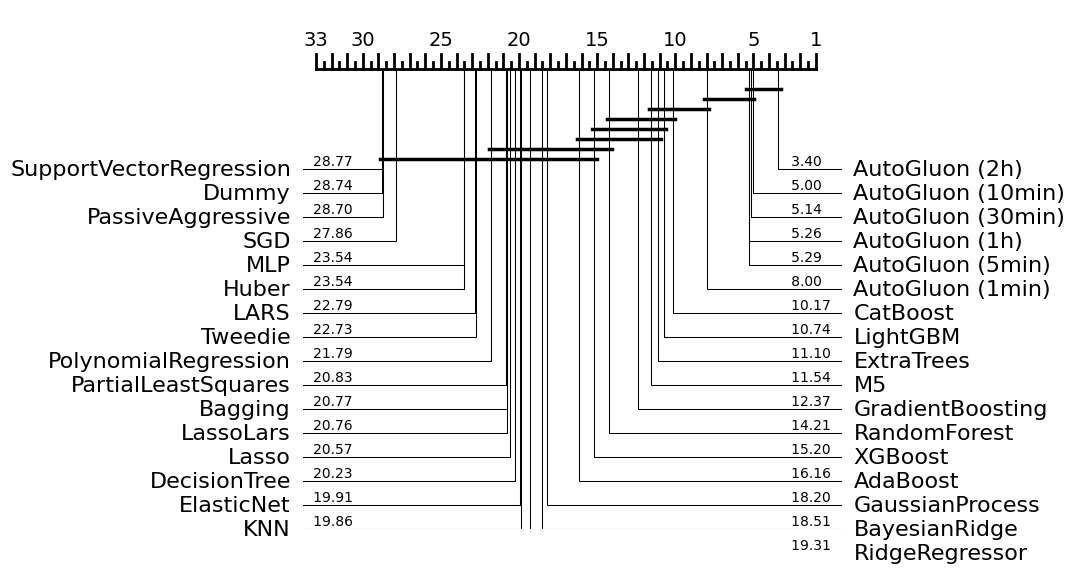

In [12]:
# Set the figure size before plotting
plt.figure(figsize=(16, 20))  # Adjust the figure size as needed

# Generate the critical difference diagram
fig, _ = plot_critical_difference(
    scores, 
    classifiers, 
    lower_better=False,
    test='wilcoxon',  # or nemenyi
    correction='holm', # or bonferroni or none
    alpha=0.01,
    width=6,
    textspace=1
)

# Get the current axes
ax = plt.gca()

# Adjust font size and rotation of x-axis labels
for label in ax.get_xticklabels():
    label.set_fontsize(14) 
    label.set_rotation(45) 
    label.set_horizontalalignment('right')

# Increase padding between labels and axis
ax.tick_params(axis='x', which='major', pad=20)

# Adjust margins to provide more space for labels
plt.subplots_adjust(bottom=0.1)

# Optionally adjust y-axis label font size
ax.tick_params(axis='y', labelsize=font_size)

# Save and display the plot
for txt in ax.texts:
    if txt.get_text().isdigit():   
        # Reduce Overcrowded X-Axis
        if int(txt.get_text()) % 5 != 0 and (int(txt.get_text()) not in (len(classifiers), 1)):
            txt.set_visible(False)
        else:
            txt.set_fontsize(font_size)
    else:
        # Round Rankings
        try: 
            value = float(txt.get_text())
            txt.set_text(f"   {value:.2f}   ")
            #txt.set_fontsize(font_size)
        except:
            pass


plt.savefig('critical_difference_diagram.pdf', format="pdf", bbox_inches="tight", pad_inches=0.5, dpi=900)
plt.show()